In [1]:
caffe_root = '/home/ai2-bb8/Documents/code/caffe' 
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
from caffe import layers as L, params as P
from caffe.proto import caffe_pb2
import os
from pylab import *
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import lmdb
import time
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
class DepthNetDeploy(object):
    """ This class implements depth net for single image inference 
    
    Attributes: 
        deploy_prototxt (str)              : directory location of the deploy prototxt
        weights (str)                      : directory location of the .caffemodel file
        net (caffe.Net)                    : caffe net object that is loaded
        transformer (caffe.io.transformer) : caffe transformer object that preprocesses inputs
        
    """
    
    def __init__(self, deploy_prototxt, weights):
        """ Initialize with the deploy prototxt and weights file of the model
        
        Args: 
            deploy_prototxt (str) : directory location of the deploy prototxt
            weights (str)         : directory location of the .caffemodel file
            
        """
        
        self.deploy_prototxt = deploy_prototxt
        self.weights = weights
        self.net = caffe.Net(deploy_prototxt, weights, caffe.TEST)
        self.transformer = caffe.io.Transformer({'data': self.net.blobs['data'].data.shape})
        
    def set_transformer(self, mean_file):
        """ Defines transformer parameters
        
        The transformer subtracts the mean pixel from an input image, applies a transpose
        to the input image into the form (C, H, W), and swaps channel from RGB to BGR
        
        Args:
            mean_file (str) : directory location of mean pixel binaryproto file
            
        """
        blob = caffe.proto.caffe_pb2.BlobProto()
        mean = open(mean_file, 'rb').read()
        blob.ParseFromString(mean)
        mean_npy = np.array(caffe.io.blobproto_to_array(blob))
        mean_npy = mean_npy[0]

        # subtract the mean scaled by 255
        self.transformer.set_mean('data', mean_npy.mean(1).mean(1)/255.0)
        self.transformer.set_transpose('data', (2,0,1))
        self.transformer.set_channel_swap('data', (2,1,0))

        #self.net.blobs['data'].reshape(1,3,240,320)
        
    def test_model(self, test_image):
        """ Run an image through the model and predict the depth
        
        The input image is processed through the transformer, passed through the depth net, 
        and a depth prediction is displayed along with the original input image
        
        Args:
            test_image (str) : directory location of the test image file
            
        Returns:
            cv2 image : depth prediction matrix
            
        """
        # image is loaded with values between 0 and 1
        im = caffe.io.load_image(test_image)
        self.net.blobs['data'].data[...] = self.transformer.preprocess('data', im)

        out = self.net.forward()
        
        layer_names = []
        for i in range(len(self.net.blobs.items())):
            layer_names.append([k for k, v in self.net.blobs.items()][i])
            
        pred = out[layer_names[-1]].reshape(self.net.blobs['data'].shape[2],self.net.blobs['data'].shape[3])
        
        return pred

In [3]:
model = '/home/ai2-bb8/Documents/code/paul/depth_net/weights/VGG_depth_net_fine_320x240_rel_iter_50000.caffemodel'
deploy_prototxt = '/home/ai2-bb8/Documents/code/paul/depth_net/VGG_depth_net_fine_deploy.prototxt'

test_net = DepthNetDeploy(deploy_prototxt, model)

In [4]:
mean_file = '/media/ai2-bb8/data_disk/data_sets/robot_depthRGB/robotDepthRGB_320x240mean.binaryproto'
test_net.set_transformer(mean_file)

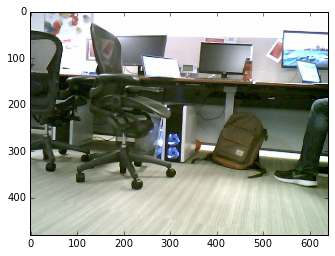

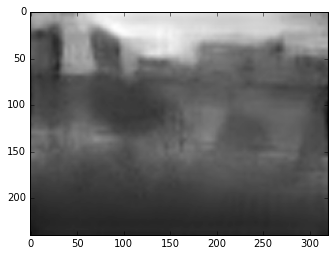

In [5]:
test_image = '/home/ai2-bb8/Documents/code/paul/depth_net/demo_pic4.jpg'

pred = test_net.test_model(test_image)

img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(0)
plt.imshow(img)
plt.figure(1)
plt.imshow(pred, cmap='gray')